In [2]:
import lightgbm as lgbm
from hyperopt import hp, tpe, Trials
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from utils.preprocessing import preprocessing 
from utils.utils import initial_hyperparam_search,cast_params_to_proper_types,lgb_f1_score,feature_imp_lgbm,filter_out_features_based_on_statistical_approach
import pickle

from lightgbm import plot_importance
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score,f1_score,confusion_matrix,precision_score,recall_score,roc_curve


In [3]:
prepos= preprocessing()
df_credit_application = prepos.read_data("credit_applications.csv")
df_customers = prepos.read_data("customers.csv")
df_customers.drop("Unnamed: 0",axis=1,inplace=True)
df_credit_application.drop("Unnamed: 0",axis=1,inplace=True)

In [4]:
df_complete_data = df_customers.merge(df_credit_application,how="inner",on=["client_nr","yearmonth"])
df_complete_data.drop("nr_credit_applications",axis=1,inplace=True)
print(df_complete_data.shape)

(29996, 11)


In [5]:
df_complete_data.describe()

,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,credit_application
count,29996.000000,29996.000000,29996.000000,29996.000000,2.999600e+04,29996.000000,2.999600e+04,2.999600e+04,2.999600e+04,24459.000000,29996.000000
mean,481.560775,201493.675157,166.427957,75.785571,1.121290e+07,90.642386,1.126906e+07,-5.523773e+06,3.752693e+06,3.251850,0.067509
std,281.317753,77.361645,220.947519,60.063496,1.617596e+07,192.244770,1.624998e+07,1.357517e+07,1.616937e+07,1.889136,0.250906
min,1.000000,201401.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-3.467127e+08,-2.485206e+08,1.000000,0.000000
25%,237.000000,201409.000000,76.000000,38.000000,3.072750e+06,33.000000,3.148068e+06,-7.895864e+06,-1.868002e+06,2.000000,0.000000
50%,479.000000,201505.000000,129.000000,66.000000,6.822769e+06,56.000000,6.934694e+06,-2.957198e+06,1.040998e+06,3.000000,0.000000
75%,721.000000,201601.000000,205.000000,101.000000,1.386656e+07,102.000000,1.394257e+07,1.690275e+04,5.806224e+06,4.000000,0.000000
max,1000.000000,201608.000000,6341.000000,1590.000000,7.980480e+08,6325.000000,8.775321e+08,2.109783e+08,3.722319e+08,7.000000,1.000000


<Axes: xlabel='credit_application', ylabel='count'>

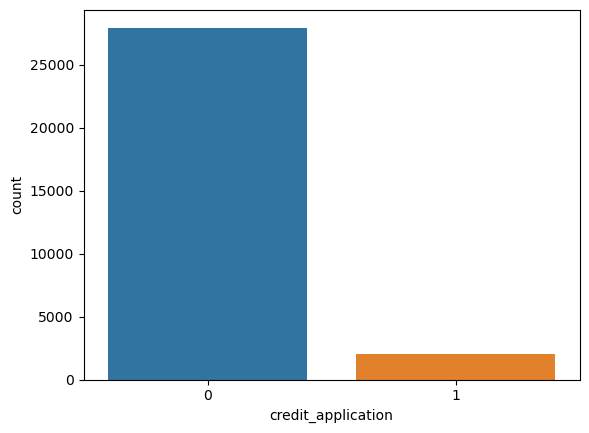

In [6]:
sns.countplot(x=df_complete_data["credit_application"])

# 0    27971
# 1     2025

In [7]:
prepos.missing_values_intable(df_complete_data)

,Missing Values,Percentage of missing values
client_nr,0,0.000000
yearmonth,0,0.000000
total_nr_trx,0,0.000000
nr_debit_trx,0,0.000000
volume_debit_trx,0,0.000000
nr_credit_trx,0,0.000000
volume_credit_trx,0,0.000000
min_balance,0,0.000000
max_balance,0,0.000000
CRG,5537,18.459128


<Axes: >

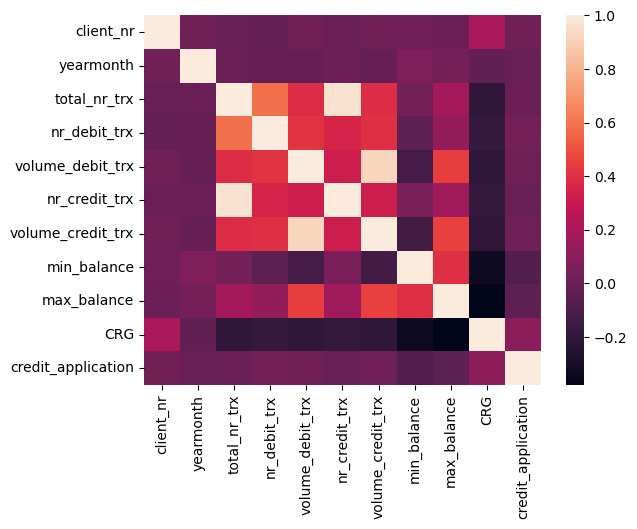

In [8]:
corl= df_complete_data.corr()
sns.heatmap(corl, 
            xticklabels=corl.columns.values,
            yticklabels=corl.columns.values)



In [9]:

# fimp=feature_importances()
X_train_feature_selection, accepted_columns,assoc_result,disallowed_columns = filter_out_features_based_on_statistical_approach(df_complete_data,[],"credit_application")
print(accepted_columns)
print(assoc_result["credit_application"].sort_values(ascending=False))

Removing columns: []
['min_balance', 'CRG', 'credit_application']
credit_application    1.00
CRG                   0.13
min_balance           0.08
max_balance           0.04
nr_debit_trx          0.03
client_nr             0.02
yearmonth             0.01
volume_debit_trx      0.01
nr_credit_trx         0.01
volume_credit_trx     0.01
total_nr_trx          0.00
Name: credit_application, dtype: float64


In [10]:
df_complete_data = df_complete_data[~df_complete_data["CRG"].isna()]
df_complete_data.describe()

,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,credit_application
count,24459.000000,24459.000000,24459.000000,24459.000000,2.445900e+04,24459.000000,2.445900e+04,2.445900e+04,2.445900e+04,24459.000000,24459.000000
mean,469.299317,201493.476471,161.691974,78.912875,1.054171e+07,82.779100,1.057677e+07,-6.704420e+06,1.837832e+06,3.251850,0.076986
std,273.731117,77.314666,134.775849,55.771395,1.410595e+07,92.514359,1.403486e+07,1.324650e+07,1.369087e+07,1.889136,0.266575
min,1.000000,201401.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-3.467127e+08,-1.986447e+08,1.000000,0.000000
25%,237.000000,201409.000000,82.000000,42.000000,3.300231e+06,34.000000,3.338818e+06,-8.998246e+06,-2.839296e+06,2.000000,0.000000
50%,463.000000,201505.000000,131.000000,68.000000,6.783566e+06,57.000000,6.839510e+06,-4.164044e+06,5.269600e+05,3.000000,0.000000
75%,691.000000,201512.000000,204.000000,103.000000,1.311511e+07,100.000000,1.318977e+07,-9.432600e+04,4.290830e+06,4.000000,0.000000
max,988.000000,201608.000000,1830.000000,567.000000,3.685273e+08,1506.000000,4.000308e+08,5.683120e+07,1.386983e+08,7.000000,1.000000


In [11]:
df_credit_applied = df_complete_data[df_complete_data["credit_application"]==1]
df_credit_not_applied = df_complete_data[df_complete_data["credit_application"]==0]


In [12]:
df_credit_applied.describe()

,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,credit_application
count,1883.000000,1883.000000,1883.000000,1883.000000,1.883000e+03,1883.000000,1.883000e+03,1.883000e+03,1.883000e+03,1883.000000,1883.0
mean,500.077536,201491.560276,164.551779,82.551779,1.091583e+07,82.000000,1.103553e+07,-9.219318e+06,4.921372e+05,3.938396,1.0
std,278.853672,74.600858,118.688574,54.472934,1.426407e+07,75.491609,1.381656e+07,1.396383e+07,9.967135e+06,2.007273,0.0
min,3.000000,201401.000000,3.000000,1.000000,1.640000e+03,0.000000,0.000000e+00,-2.512930e+08,-4.969930e+07,1.000000,1.0
25%,261.000000,201409.000000,88.000000,46.000000,3.596187e+06,37.000000,3.597184e+06,-1.246202e+07,-3.286638e+06,3.000000,1.0
50%,518.000000,201505.000000,136.000000,72.000000,6.928000e+06,58.000000,7.219140e+06,-5.901753e+06,2.122350e+05,3.000000,1.0
75%,728.000000,201512.000000,211.000000,109.000000,1.315141e+07,102.000000,1.331102e+07,-2.304337e+06,2.955748e+06,7.000000,1.0
max,987.000000,201608.000000,1632.000000,567.000000,2.230778e+08,1226.000000,1.916246e+08,1.727436e+07,1.147000e+08,7.000000,1.0


In [13]:
df_credit_not_applied.describe()

,client_nr,yearmonth,total_nr_trx,nr_debit_trx,volume_debit_trx,nr_credit_trx,volume_credit_trx,min_balance,max_balance,CRG,credit_application
count,22576.000000,22576.000000,22576.000000,22576.000000,2.257600e+04,22576.000000,2.257600e+04,2.257600e+04,2.257600e+04,22576.000000,22576.0
mean,466.732193,201493.636295,161.453446,78.609364,1.051050e+07,82.844082,1.053850e+07,-6.494659e+06,1.950073e+06,3.194587,0.0
std,273.149148,77.536185,136.031344,55.868805,1.409255e+07,93.795805,1.405254e+07,1.316354e+07,1.395094e+07,1.867626,0.0
min,1.000000,201401.000000,1.000000,0.000000,0.000000e+00,0.000000,0.000000e+00,-3.467127e+08,-1.986447e+08,1.000000,0.0
25%,236.000000,201408.000000,81.000000,42.000000,3.265849e+06,34.000000,3.314907e+06,-8.733733e+06,-2.801805e+06,2.000000,0.0
50%,460.000000,201504.000000,130.000000,68.000000,6.771628e+06,57.000000,6.812971e+06,-4.001845e+06,5.600740e+05,3.000000,0.0
75%,688.000000,201601.000000,204.000000,103.000000,1.310775e+07,100.000000,1.317681e+07,-2.916450e+04,4.382616e+06,4.000000,0.0
max,988.000000,201608.000000,1830.000000,565.000000,3.685273e+08,1506.000000,4.000308e+08,5.683120e+07,1.386983e+08,7.000000,0.0


<Axes: xlabel='CRG', ylabel='count'>

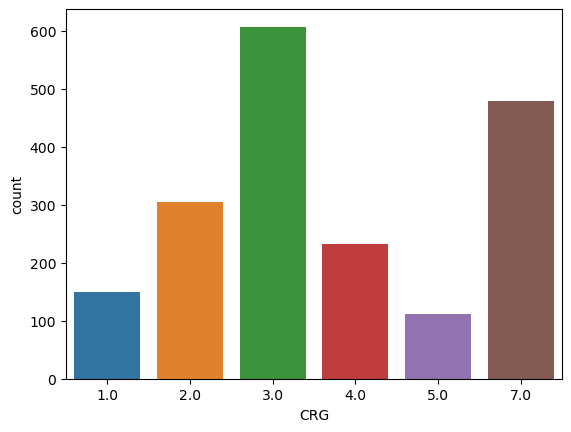

In [14]:
sns.countplot(x=df_credit_applied["CRG"])

<Axes: xlabel='CRG', ylabel='count'>

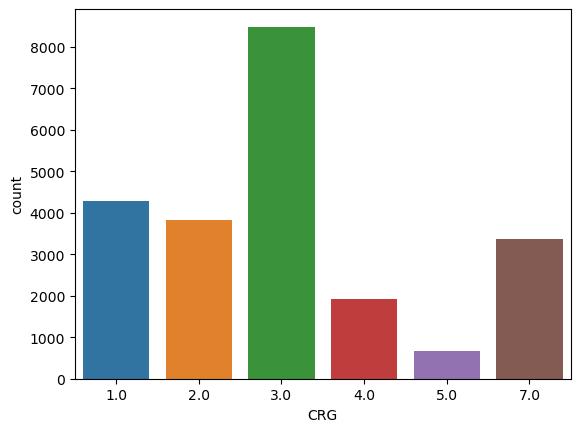

In [15]:
sns.countplot(x=df_credit_not_applied["CRG"])

In [16]:
plt.rcParams["figure.figsize"] = [3,3]  #set the graph to a smaller size 


<Axes: >

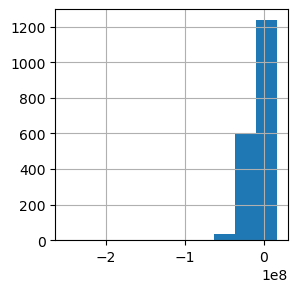

In [17]:
df_credit_applied["min_balance"].hist()

<Axes: >

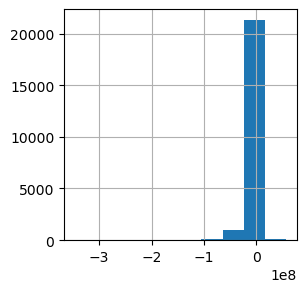

In [18]:
df_credit_not_applied["min_balance"].hist()

<Axes: >

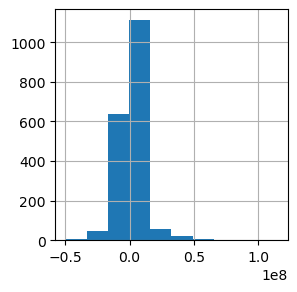

In [19]:
df_credit_applied["max_balance"].hist()

<Axes: >

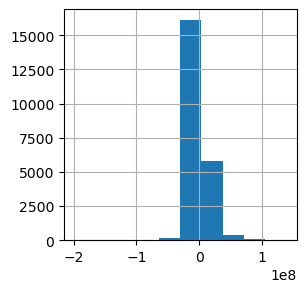

In [20]:
df_credit_not_applied["max_balance"].hist()

###### Month and year features and EDA

In [21]:
# df_complete_data["year_month_str"]=df_complete_data.yearmonth.astype(str)
# df_complete_data["month"]=df_complete_data["year_month_str"].apply(lambda x: x[-2:])
# df_complete_data["year"]=df_complete_data["year_month_str"].apply(lambda x: x[:-2])
# # df_complete_data["year"]
# df_complete_data.drop(["year_month_str"],axis=1,inplace=True)
# df_complete_data["year"]= df_complete_data["year"].astype(int)
# df_complete_data["month"]= df_complete_data["year"].astype(int)
# sns.countplot(data=df_complete_data,x="month")
# sns.countplot(data=df_credit_applied,x="month")
# sns.countplot(data=df_credit_not_applied,x="month")
# sns.countplot(data=df_complete_data,x="year")
# sns.countplot(data=df_credit_applied,x="year")
# sns.countplot(data=df_credit_not_applied,x="year")

###### New features ideas
<b>1.credit_applied_before_ratio </b> - Calculate how many times client has applied for credit in the past for each month

In [22]:
def calculate_nr_credit_in_past(current_index):
    client_nr = df_complete_data.loc[[current_index]]["client_nr"].values[0]
    tmp_sum = df_complete_data[(df_complete_data["client_nr"]==client_nr) & (df_complete_data.index <current_index)]["credit_application"].sum()
    tmp_cnt = df_complete_data[(df_complete_data["client_nr"]==client_nr) & (df_complete_data.index <current_index)]["credit_application"].count()
    if(tmp_cnt==0):
        return 0
    else:
        return tmp_sum/tmp_cnt
    
    


In [23]:
df_complete_data["credit_applied_before_ratio"]= df_complete_data.index.map(calculate_nr_credit_in_past)

 ###### 2. debit_credit_ratio
 From the outside, I'd expect customer will need loan if debit amount is roughly about 80% or more of credit amount.
 <br>e.g: If my expense(debit_amount) is more than salary(credit), its natural to have the need for the credit. 

In [24]:
# plt.rcParams["figure.figsize"] = [5,5]  #set the graph to a smaller size 
df_complete_data["debit_credit_ratio"]=df_complete_data["volume_debit_trx"]/df_complete_data["volume_credit_trx"]
df_complete_data["debit_credit_ratio"] = np.where(df_complete_data["debit_credit_ratio"]==np.inf,df_complete_data["volume_debit_trx"],df_complete_data["debit_credit_ratio"])

 ###### 3.Is_debit_more_average
 
 Is volume_debit_trx is more than the average of the volume_debit_trx for that client
 <br>If yes 1 else 0

In [25]:
# debit_average_per_client = df_complete_data.groupby(["client_nr"]).mean()["volume_debit_trx"].reset_index()
# df_complete_data["debit_average_per_client"] = df_complete_data["client_nr"].apply(lambda x: debit_average_per_client[debit_average_per_client["client_nr"]==x]["volume_debit_trx"].values[0])
# df_complete_data["Is_debit_more_average"]=np.where(df_complete_data["debit_average_per_client"] < df_complete_data["volume_debit_trx"],1,0)
# df_complete_data.drop(["debit_average_per_client"],axis=1,inplace=True)

#### Split data strategy

As part of train/test data split, 20% of data will be reserved as test data and will not seen by any model.
<br>That amounts to approximately = 6 months worth of data.
<br>Instead of splitting train/test data randomly, I decided to leave last 6 month data as test data set i.e. March 2016 to August 2016

In [26]:
def Split_data(df_complete_data):
    X_test = df_complete_data[df_complete_data["yearmonth"].isin([201608,201607,201606,201605,201604,201603])].copy()
    y_test = X_test["credit_application"]

    X_train_org = df_complete_data[~df_complete_data["yearmonth"].isin([201608,201607,201606,201605,201604,201603])].copy()
    y_train_org = X_train_org["credit_application"]

    X_train,X_val,y_train,y_val=train_test_split(X_train_org,X_train_org["credit_application"],test_size=0.2,random_state=42,stratify=X_train_org["credit_application"])

    X_test.drop(["credit_application"],axis=1,inplace=True)
    X_train_org.drop(["credit_application","client_nr"],axis=1,inplace=True)
    X_train.drop(["credit_application","client_nr"],axis=1,inplace=True)
    X_val.drop(["credit_application","client_nr"],axis=1,inplace=True)
    
    return X_train_org,X_train,X_val,X_test,y_train_org,y_train,y_test,y_val
    

In [27]:
X_train_org,X_train,X_val,X_test,y_train_org,y_train,y_test,y_val=Split_data(df_complete_data)

##### 2. Using Lightgbm feature importance

In [28]:

params_scope = {
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
    'num_leaves': hp.quniform('num_leaves', 2, 15, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 500, 10),
    'scale_pos_weight': hp.quniform('scale_pos_weight', 5, 100, 5),
    'reg_lambda ': hp.uniform('reg_lambda', 10.00, 100.0),
    'pos_bagging_fraction': hp.uniform('pos_bagging_fraction', 0.0, 1.0),
    'max_bin': hp.quniform('max_bin', 16, 256, 16)
                            }


In [29]:
model,initial_params = feature_imp_lgbm(X_train,y_train,X_val,y_val,params_scope)
feature_imp_df = pd.DataFrame(data={'feature_name':model.feature_name_,
                   'feature_importance':model.feature_importances_},
            
            )
feature_imp_df.sort_values(by="feature_importance",ascending=False,inplace=True)

100%|██████████████████████████████████████████████| 250/250 [02:48<00:00,  1.48trial/s, best loss: 0.7542857142857142]


C:\Users\vishalra\Anaconda3\envs\nlp_tasks\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


In [30]:
print(initial_params)
feature_imp_df

{'learning_rate': 0.014673918807559042, 'max_bin': 112.0, 'n_estimators': 100.0, 'num_leaves': 11.0, 'pos_bagging_fraction': 0.9332269881860231, 'reg_lambda': 55.281614179062075, 'scale_pos_weight': 15.0}


,feature_name,feature_importance
6,min_balance,158
8,CRG,152
2,nr_debit_trx,139
9,credit_applied_before_ratio,120
10,debit_credit_ratio,87
0,yearmonth,85
7,max_balance,70
4,nr_credit_trx,64
3,volume_debit_trx,55
1,total_nr_trx,47


##### Based on statistical imp,heatmap and lgbm feature importances below columns can be dropped

In [31]:
X_train.drop(["volume_credit_trx","volume_debit_trx","total_nr_trx"],axis=1,inplace=True)
X_train_org.drop(["volume_credit_trx","volume_debit_trx","total_nr_trx"],axis=1,inplace=True)

In [32]:
import lightgbm as lgb
params = cast_params_to_proper_types(initial_params)
model = lgb.LGBMClassifier(
        random_state=42,
        verbose=-1,
        objective='binary'
        ,**params
)   

model.fit(
X_train_org,
y_train_org,
eval_set=[(X_val[X_train_org.columns], y_val)],
verbose=0,
eval_metric=lgb_f1_score
)

C:\Users\vishalra\Anaconda3\envs\nlp_tasks\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(learning_rate=0.014673918807559042, max_bin=112, num_leaves=11,
               objective='binary', random_state=42, scale_pos_weight=15,
               verbose=-1)

C:\Users\vishalra\Anaconda3\envs\nlp_tasks\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


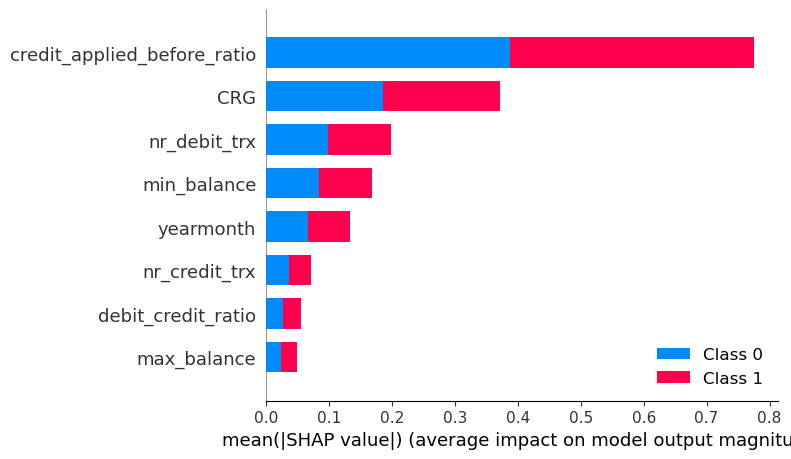

In [33]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_val[X_train.columns])
shap.summary_plot(shap_values, X_val[X_train.columns], plot_type="bar")

In [34]:
def cross_validation(model,X_train_org,y_train_org,threshold):
    
    kfolds = StratifiedKFold(5)
    current_f1_scores=[]
    roc_auc_scores_val=[]
    precision_score_val=[]
    recall_score_val=[]
    fpr_scores=[]
    tpr_scores=[]

    
    
    for train_idx ,val_index in kfolds.split(X_train_org,y_train_org):
        model.fit(
                    X_train_org.iloc[train_idx],
                    y_train_org.iloc[train_idx]
#                   ,eval_metric=lgb_f1_score
                )
        y_pred=np.where(model.predict_proba(X_train_org.iloc[val_index])[:,1] >threshold,1,0)
        current_f1_scores.append(f1_score(y_train_org.iloc[val_index], y_pred))
        tn, fp, fn, tp = confusion_matrix(y_train_org.iloc[val_index],y_pred).ravel()
        print(confusion_matrix(y_train_org.iloc[val_index],y_pred))
        roc_auc_scores_val.append(roc_auc_score(y_train_org.iloc[val_index], y_pred))
        precision_score_val.append(precision_score(y_true=y_train_org.iloc[val_index],y_pred=y_pred))
        recall_score_val.append(recall_score(y_true=y_train_org.iloc[val_index],y_pred=y_pred))
        fpr_val, tpr_val, _ = roc_curve(y_true=y_train_org.iloc[val_index], y_score=y_pred)
        fpr_scores.append(fpr_val)
        tpr_scores.append(tpr_val)
    
    return current_f1_scores,roc_auc_scores_val,precision_score_val,recall_score_val,fpr_scores,tpr_scores

    

def plot_roc(fpr,tpr,roc_auc,color_ip):
    print('ROC AUC=%0.2f'%roc_auc)
    plt.plot(fpr,tpr,label='AUC=%0.2f'%roc_auc,color=color_ip)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'b--')
    plt.xlim([0,1])
    plt.ylim([0,1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.grid(True) 
#     plt.show()

In [35]:
current_f1_scores,roc_auc_scores_val,precision_score_val,recall_score_val,fpr_scores,tpr_scores=cross_validation(model,X_train_org,y_train_org,0.4)

[[2168 1500]
 [  78  234]]
[[1917 1750]
 [  76  236]]
[[1975 1692]
 [  75  237]]
[[1492 2175]
 [  61  251]]
[[1559 2108]
 [  51  261]]


ROC AUC=0.67
ROC AUC=0.64
ROC AUC=0.65
ROC AUC=0.61
ROC AUC=0.63
Mean ROC AUC score on validation data =0.64


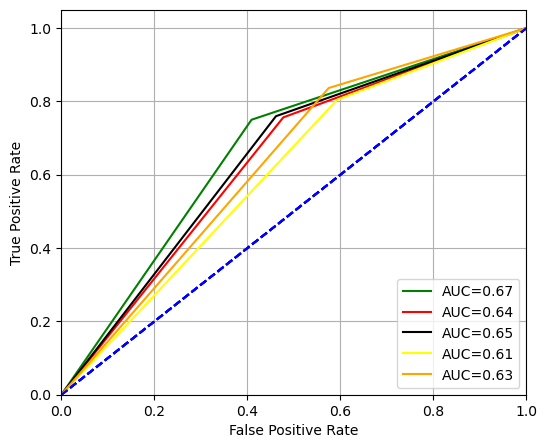

In [47]:
plt.rcParams["figure.figsize"] = [6,5]  #set the graph to a smaller size 

color_list=["green","red","black","yellow","orange"]
for fpr_val,tpr_val,roc_auc_score,color in zip(fpr_scores,tpr_scores,roc_auc_scores_val,color_list):
    plot_roc(fpr_val,tpr_val,roc_auc_score,color)
    
    
print('Mean ROC AUC score on validation data =%0.2f'%np.mean(roc_auc_scores_val))

In [37]:
def print_metrics(f1_scores,recall_scores,precision_scores,dataset="validation"):
    print("F1 scores on "+ dataset+" data:")
    print(f1_scores)
    print("-----------------------------------------------------")
    print("Recall scores on "+ dataset+" data:")
    print(recall_scores)
    print("-----------------------------------------------------")
    print("Mean f1 score on "+ dataset+" data:")
    print(np.mean(f1_scores))

    print("-----------------------------------------------------")
    print("Mean recall score on "+ dataset+" data:")
    print(np.mean(recall_scores))

    print("-----------------------------------------------------")
    print("Mean precision score on "+ dataset+" data:")
    print(np.mean(precision_scores))

In [38]:
print_metrics(current_f1_scores,recall_score_val,precision_score_val,"validation")

F1 scores on validation data:
[0.22873900293255134, 0.2053959965187119, 0.2115127175368139, 0.183345507669832, 0.1947034688549049]
-----------------------------------------------------
Recall scores on validation data:
[0.75, 0.7564102564102564, 0.7596153846153846, 0.8044871794871795, 0.8365384615384616]
-----------------------------------------------------
Mean f1 score on validation data:
0.2047393387025628
-----------------------------------------------------
Mean recall score on validation data:
0.7814102564102564
-----------------------------------------------------
Mean precision score on validation data:
0.118055412891931


###### On test data

In [39]:
# y_test_pred = model.predict(X_test)
for i in np.arange(0.3,0.65,0.051):
    i=(round(i,2))
    print("---------------THRESHOLD ="+str(i)+" ----------------------")

    y_test_pred=np.where(model.predict_proba(X_test[X_train.columns])[:,1] >i,1,0)

    print(confusion_matrix(y_test,y_test_pred))
    print("F1 score on Test data:")
    print(f1_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Recall score on Test data:")
    print(recall_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Precision score on Test data:")
    print(precision_score(y_test,y_test_pred))

---------------THRESHOLD =0.3 ----------------------
[[1947 2293]
 [  48  275]]
F1 score on Test data:
0.19024558976132827
-----------------------------------------------------
Recall score on Test data:
0.8513931888544891
-----------------------------------------------------
Precision score on Test data:
0.10708722741433022
---------------THRESHOLD =0.35 ----------------------
[[2106 2134]
 [  57  266]]
F1 score on Test data:
0.19537275064267354
-----------------------------------------------------
Recall score on Test data:
0.8235294117647058
-----------------------------------------------------
Precision score on Test data:
0.11083333333333334
---------------THRESHOLD =0.4 ----------------------
[[2226 2014]
 [  61  262]]
F1 score on Test data:
0.20161600615621394
-----------------------------------------------------
Recall score on Test data:
0.8111455108359134
-----------------------------------------------------
Precision score on Test data:
0.11511423550087874
---------------THR

In [40]:
# X_test=X_test[X_train.columns]
y_test_pred=np.where(model.predict_proba(X_test[X_train.columns])[:,1] >0.45,1,0)
print(confusion_matrix(y_test,y_test_pred))
print("F1 score on Test data:")
print(f1_score(y_test,y_test_pred))
print("-----------------------------------------------------")
print("Recall score on Test data:")
print(recall_score(y_test,y_test_pred))
print("-----------------------------------------------------")
print("Precision score on Test data:")
print(precision_score(y_test,y_test_pred))

[[2309 1931]
 [  67  256]]
F1 score on Test data:
0.20398406374501993
-----------------------------------------------------
Recall score on Test data:
0.7925696594427245
-----------------------------------------------------
Precision score on Test data:
0.11705532693187014


In [41]:
### Save preds to csv file

X_test["ground_truth"] = y_test
X_test["pred_lgbm"]=y_test_pred
# X_test.to_csv("output files/predictions_on_test_set_lgbm.csv")
# pickle.dump(model,open('output files/model_lgbm.pkl','wb'))


###### SVM 

In [33]:
# from sklearn.preprocessing import StandardScaler,MinMaxScaler
# std=StandardScaler()
# Xformed_data = std.fit_transform(X_train_org)
# Xformed_data = pd.DataFrame(Xformed_data,columns=X_train_org.columns)
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.svm import SVC
# def svm_hyper(X_train_transformed, y_train):
#     svc = SVC()
#     C_range = [0.001,0.1,1,10]
# #     gamma_range = [0.001,0.1,1,'scale', 'auto']    
#     param_grid = { 
#         "C": C_range,
#         "kernel": ['rbf', 'poly']
# #         ,"gamma": gamma_range
#         }
#     print(param_grid)
#     scoring = ['f1']
# #     kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
#     random_search = RandomizedSearchCV(estimator=svc, 
#                                param_distributions=param_grid, 
#                                n_iter=5,
#                                scoring=scoring,
#                                refit="f1",        
#                                n_jobs=-1, 
#                                cv=3)
#     # Fit grid search
#     random_result = random_search.fit(X_train_transformed, y_train)
#     # Print grid search summary
#     model = random_search.best_estimator_
#     return model,random_search

# model,random_search = svm_hyper(Xformed_data,y_train_org)
# import pickle
# # pickle.dump(model,open("output files/model_svm.pkl","wb"))
# model_svm = pickle.load(open("output files/model_svm.pkl","rb"))
# y_test_pred = model_svm.predict(X_test[X_train.columns])
# print(confusion_matrix(y_test_pred,y_test))
# print(f1_score(y_test_pred,y_test))


###### Random forest 

In [48]:
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.model_selection import cross_val_score,RandomizedSearchCV


In [49]:

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]

max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4,10]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random_grid

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
 'max_features': ['auto', 'sqrt'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4, 10],
 'bootstrap': [True, False]}

In [50]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    model_rf = BalancedRandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator = model_rf, param_distributions = random_grid, n_iter = 10, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    rf_random.fit(X_train_org, y_train_org)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [51]:
rf_random.best_estimator_

BalancedRandomForestClassifier(max_depth=20, min_samples_leaf=10,
                               min_samples_split=5, n_estimators=700)

In [52]:
model_rf=rf_random.best_estimator_

In [55]:
print_metrics(current_f1_scores,recall_score_val,precision_score_val,"validation")

F1 scores on validation data:
[0.22873900293255134, 0.2053959965187119, 0.2115127175368139, 0.183345507669832, 0.1947034688549049]
-----------------------------------------------------
Recall scores on validation data:
[0.75, 0.7564102564102564, 0.7596153846153846, 0.8044871794871795, 0.8365384615384616]
-----------------------------------------------------
Mean f1 score on validation data:
0.2047393387025628
-----------------------------------------------------
Mean recall score on validation data:
0.7814102564102564
-----------------------------------------------------
Mean precision score on validation data:
0.118055412891931


In [56]:
# y_test_pred = model.predict(X_test)
for i in np.arange(0.3,0.65,0.051):
    i=(round(i,2))
    print("---------------THRESHOLD ="+str(i)+" ----------------------")

    y_test_pred=np.where(model_rf.predict_proba(X_test[X_train.columns])[:,1] >i,1,0)

    print(confusion_matrix(y_test,y_test_pred))
    print("F1 score on Test data:")
    print(f1_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Recall score on Test data:")
    print(recall_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Precision score on Test data:")
    print(precision_score(y_test,y_test_pred))

---------------THRESHOLD =0.3 ----------------------
[[1482 2758]
 [  26  297]]
F1 score on Test data:
0.17584369449378331
-----------------------------------------------------
Recall score on Test data:
0.9195046439628483
-----------------------------------------------------
Precision score on Test data:
0.0972176759410802
---------------THRESHOLD =0.35 ----------------------
[[1866 2374]
 [  37  286]]
F1 score on Test data:
0.19175326852162253
-----------------------------------------------------
Recall score on Test data:
0.8854489164086687
-----------------------------------------------------
Precision score on Test data:
0.10751879699248121
---------------THRESHOLD =0.4 ----------------------
[[2124 2116]
 [  55  268]]
F1 score on Test data:
0.19800517177687477
-----------------------------------------------------
Recall score on Test data:
0.8297213622291022
-----------------------------------------------------
Precision score on Test data:
0.11241610738255034
---------------THRE

In [57]:

y_test_pred=np.where(model_rf.predict_proba(X_test[X_train.columns])[:,1] >0.45,1,0)
print(confusion_matrix(y_test,y_test_pred))
print("F1 score on Test data:")
print(f1_score(y_test,y_test_pred))
print("-----------------------------------------------------")
print("Recall score on Test data:")
print(recall_score(y_test,y_test_pred))
print("-----------------------------------------------------")
print("Precision score on Test data:")
print(precision_score(y_test,y_test_pred))

[[2487 1753]
 [  77  246]]
F1 score on Test data:
0.21188630490956073
-----------------------------------------------------
Recall score on Test data:
0.7616099071207431
-----------------------------------------------------
Precision score on Test data:
0.12306153076538269


In [58]:
### Save preds to csv file

X_test["ground_truth"] = y_test
X_test["pred_rf"]=y_test_pred
# X_test.to_csv("output files/predictions_on_test_set_rf_threshold_0.5.csv")


# pickle.dump(model,open("output files/model_rf.pkl","wb"))

##### Unsupervised (Isolation forest)

In [59]:

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import ParameterSampler
from sklearn.metrics import f1_score,roc_auc_score,confusion_matrix,recall_score,precision_score

In [60]:
model_iso = IsolationForest(contamination=0.03, max_features=0.1, max_samples=0.1,n_estimators=230)
model_iso.fit(X_train_org)

X does not have valid feature names, but IsolationForest was fitted with feature names


IsolationForest(contamination=0.03, max_features=0.1, max_samples=0.1,
                n_estimators=230)

In [61]:
model_iso.predict(X_test[X_train.columns])
y_test_pred = model_iso.predict(X_test[X_train.columns])
y_test_pred = [1 if x==-1 else 0 for x in y_test_pred ]
score = f1_score(y_test, y_test_pred)

In [62]:
print(score)
print(recall_score(y_test, y_test_pred))

0.10426540284360189
0.1021671826625387


In [63]:
X_test["iso_pred"]=y_test_pred

##### Ensemble voting

In [64]:
X_test["final_pred"]=np.where(X_test["pred_lgbm"]+X_test["pred_rf"]+X_test["iso_pred"]>1,1,0)

In [65]:
print(f1_score(X_test["ground_truth"],X_test["final_pred"]))
print(recall_score(X_test["ground_truth"],X_test["final_pred"]))
print(precision_score(X_test["ground_truth"],X_test["final_pred"]))
confusion_matrix(X_test["ground_truth"],X_test["final_pred"])

0.2171945701357466
0.7430340557275542
0.1271860095389507


array([[2593, 1647],
       [  83,  240]], dtype=int64)

In [ ]:
# pickle.dump(model_iso,open('output files/model_iso.pkl','wb'))
# X_test.to_csv("output files/ensemble_voting.csv")


##### New features : 
<b>4.  z_scores for below columns

In [66]:
z_cols=['total_nr_trx', 'nr_debit_trx',
       'volume_debit_trx', 'nr_credit_trx', 'volume_credit_trx', 'min_balance',
       'max_balance']

In [67]:
import scipy.stats as stats

def get_zscore_col(ip_col):
    new_col_name=ip_col+'_zscore'
    df_complete_data[new_col_name]=stats.zscore(df_complete_data[ip_col].values)
    

In [68]:
for z in z_cols:
    get_zscore_col(z)

In [69]:
X_train_org,X_train,X_val,X_test,y_train_org,y_train,y_test,y_val=Split_data(df_complete_data)
X_train.drop(["volume_credit_trx","volume_debit_trx","total_nr_trx"],axis=1,inplace=True)
X_train_org.drop(["volume_credit_trx","volume_debit_trx","total_nr_trx"],axis=1,inplace=True)

In [70]:

params_scope = {
    'learning_rate': hp.uniform('learning_rate', 0.001, 0.1),
    'num_leaves': hp.quniform('num_leaves', 2, 15, 1),
    'n_estimators': hp.quniform('n_estimators', 10, 500, 10),
    'scale_pos_weight': hp.quniform('scale_pos_weight', 5, 100, 5),
    'reg_lambda ': hp.uniform('reg_lambda', 10.00, 100.0),
    'pos_bagging_fraction': hp.uniform('pos_bagging_fraction', 0.0, 1.0),
    'max_bin': hp.quniform('max_bin', 16, 256, 16)
                            }


In [71]:
# feature_imp_df[feature_imp_df["feature_importance"]==0].feature_name.values

In [72]:
X_train.drop(['max_balance',
       'nr_debit_trx_zscore', 'volume_debit_trx_zscore',
       'nr_credit_trx_zscore', 'volume_credit_trx_zscore'],axis=1,inplace=True)

X_train_org.drop(['max_balance',
       'nr_debit_trx_zscore', 'volume_debit_trx_zscore',
       'nr_credit_trx_zscore', 'volume_credit_trx_zscore'],axis=1,inplace=True)

In [73]:
model_new,initial_params = feature_imp_lgbm(X_train,y_train,X_val,y_val,params_scope)
feature_imp_df = pd.DataFrame(data={'feature_name':model_new.feature_name_,
                   'feature_importance':model_new.feature_importances_},
            
            )
feature_imp_df.sort_values(by="feature_importance",ascending=False,inplace=True)

100%|██████████████████████████████████████████████| 250/250 [03:08<00:00,  1.33trial/s, best loss: 0.7492931196983977]


'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.


In [74]:
print(initial_params)
feature_imp_df

{'learning_rate': 0.08963777481377375, 'max_bin': 176.0, 'n_estimators': 10.0, 'num_leaves': 6.0, 'pos_bagging_fraction': 0.17944615605343356, 'reg_lambda': 32.834374467999524, 'scale_pos_weight': 20.0}


,feature_name,feature_importance
4,CRG,10
5,credit_applied_before_ratio,10
1,nr_debit_trx,7
3,min_balance,6
0,yearmonth,5
6,debit_credit_ratio,4
2,nr_credit_trx,3
8,min_balance_zscore,2
9,max_balance_zscore,2
7,total_nr_trx_zscore,1


LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


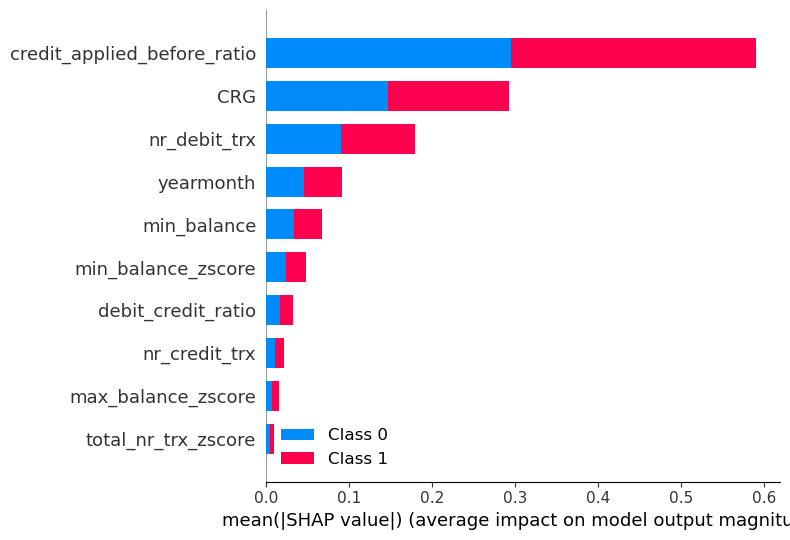

In [75]:
import shap
explainer = shap.TreeExplainer(model_new)
shap_values = explainer.shap_values(X_val[X_train.columns])
shap.summary_plot(shap_values, X_val[X_train.columns], plot_type="bar")

[[2187 1481]
 [  80  232]]
[[2080 1587]
 [  91  221]]
[[2058 1609]
 [  73  239]]
[[1562 2105]
 [  69  243]]
[[1595 2072]
 [  52  260]]
ROC AUC=0.67
ROC AUC=0.64
ROC AUC=0.66
ROC AUC=0.60
ROC AUC=0.63
Mean ROC AUC score on validation data =0.64


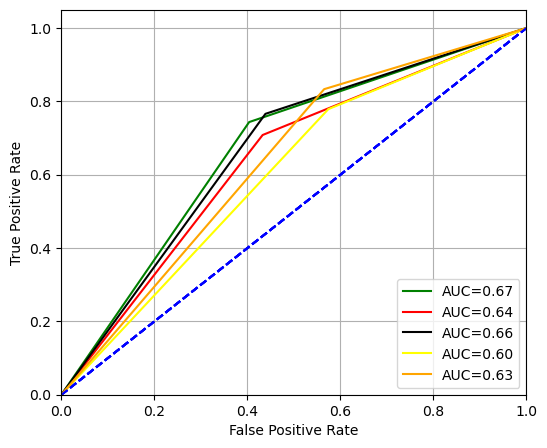

In [76]:
current_f1_scores,roc_auc_scores_val,precision_score_val,recall_score_val,fpr_scores,tpr_scores=cross_validation(model_new,X_train_org[X_train.columns],y_train_org,0.4)
color_list=["green","red","black","yellow","orange"]
for fpr_val,tpr_val,roc_auc_score,color in zip(fpr_scores,tpr_scores,roc_auc_scores_val,color_list):
    plot_roc(fpr_val,tpr_val,roc_auc_score,color)
    
    
print('Mean ROC AUC score on validation data =%0.2f'%np.mean(roc_auc_scores_val))

In [77]:
# y_test_pred = model.predict(X_test)
for i in np.arange(0.3,0.65,0.051):
    i=(round(i,2))
    print("---------------THRESHOLD ="+str(i)+" ----------------------")

    y_test_pred=np.where(model_new.predict_proba(X_test[X_train.columns])[:,1] >i,1,0)

    print(confusion_matrix(y_test,y_test_pred))
    print("F1 score on Test data:")
    print(f1_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Recall score on Test data:")
    print(recall_score(y_test,y_test_pred))
    print("-----------------------------------------------------")
    print("Precision score on Test data:")
    print(precision_score(y_test,y_test_pred))

---------------THRESHOLD =0.3 ----------------------
[[1538 2702]
 [  29  294]]
F1 score on Test data:
0.1771617957216029
-----------------------------------------------------
Recall score on Test data:
0.9102167182662538
-----------------------------------------------------
Precision score on Test data:
0.09813084112149532
---------------THRESHOLD =0.35 ----------------------
[[2024 2216]
 [  45  278]]
F1 score on Test data:
0.19737309194178204
-----------------------------------------------------
Recall score on Test data:
0.8606811145510835
-----------------------------------------------------
Precision score on Test data:
0.11146752205292702
---------------THRESHOLD =0.4 ----------------------
[[2166 2074]
 [  56  267]]
F1 score on Test data:
0.20045045045045046
-----------------------------------------------------
Recall score on Test data:
0.826625386996904
-----------------------------------------------------
Precision score on Test data:
0.11405382315249893
---------------THRES

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [78]:
# X_test=X_test[X_train.columns]
y_test_pred=np.where(model_new.predict_proba(X_test[X_train.columns])[:,1] >0.4,1,0)
print(confusion_matrix(y_test,y_test_pred))
print("F1 score on Test data:")
print(f1_score(y_test,y_test_pred))
print("-----------------------------------------------------")
print("Recall score on Test data:")
print(recall_score(y_test,y_test_pred))
print("-----------------------------------------------------")
print("Precision score on Test data:")
print(precision_score(y_test,y_test_pred))

[[2166 2074]
 [  56  267]]
F1 score on Test data:
0.20045045045045046
-----------------------------------------------------
Recall score on Test data:
0.826625386996904
-----------------------------------------------------
Precision score on Test data:
0.11405382315249893


In [79]:
# 0.20677966101694914
# 0.7554179566563467
# 0.11978399607265587
# array([[2447, 1793],
#        [  79,  244]], dtype=int64)